In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

fontsize = 14
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (15, 8)}
plt.rcParams.update(params)

In [2]:
root_path = os.path.join('..', '..', 'cleaned_logs_to_keep', 'local')
full_logs = pd.read_csv(os.path.join(root_path, 'python_local_30M_5.csv'))

In [3]:
full_logs.head(10)

,filename,nb_cores,loop_counter,command,end_of_command,accum,length
0,graph_30M_5.txt,2,0,start,2021-03-28 23:12:40.929891,0,0
1,graph_30M_5.txt,2,1,ded_reduce,2021-03-28 23:13:14.427196,3813673,4233161
2,graph_30M_5.txt,2,2,ded_reduce,2021-03-28 23:15:35.752141,7545282,7760631
3,graph_30M_5.txt,2,3,ded_reduce,2021-03-28 23:18:57.933266,14974496,9960879
4,graph_30M_5.txt,2,4,ded_reduce,2021-03-28 23:20:31.916255,19324891,841589
5,graph_30M_5.txt,2,5,ded_reduce,2021-03-28 23:20:43.394401,750098,466540
6,graph_30M_5.txt,2,6,ded_reduce,2021-03-28 23:20:52.833924,0,466540
7,graph_30M_5.txt,3,0,start,2021-03-28 23:20:53.904425,0,0
8,graph_30M_5.txt,3,1,ded_reduce,2021-03-28 23:21:26.325553,3813673,4233161
9,graph_30M_5.txt,3,2,ded_reduce,2021-03-28 23:23:47.894363,7545282,7760631


In [38]:
# full_logs.to_csv(os.path.join(root_path, 'python_web_google_rdd_df.csv'), index=False)
# full_logs.loc[full_logs['algo_type']=='python_rdd', 'algo_type'] = 'python-rdd'
# full_logs.head()

In [5]:
def get_durations(df):
    
    try:
        df['end_of_command'] = pd.to_datetime(df['end_of_command'])
        df['duration'] = df['end_of_command'].diff().dt.total_seconds()
#         df['duration'].fillna(0, inplace=True)
        df.dropna(axis=0, inplace=True)
        df.set_index('loop_counter', inplace=True)
        df['edge_per_node'] = df['filename'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))
    except:
        pass
    return df

In [6]:
two_core_logs = get_durations(full_logs[full_logs['nb_cores'] == 2])
three_core_logs = get_durations(full_logs[full_logs['nb_cores'] == 3])
four_core_logs = get_durations(full_logs[full_logs['nb_cores'] == 4])

In [7]:
print(f"duration with 2 cores = {two_core_logs['duration'].sum()} seconds")
print(f"duration with 3 cores = {three_core_logs['duration'].sum()} seconds")
print(f"duration with 4 cores = {four_core_logs['duration'].sum()} seconds")

duration with 2 cores = 491.90403299999997 seconds
duration with 3 cores = 490.53500600000007 seconds
duration with 4 cores = 491.82224700000006 seconds


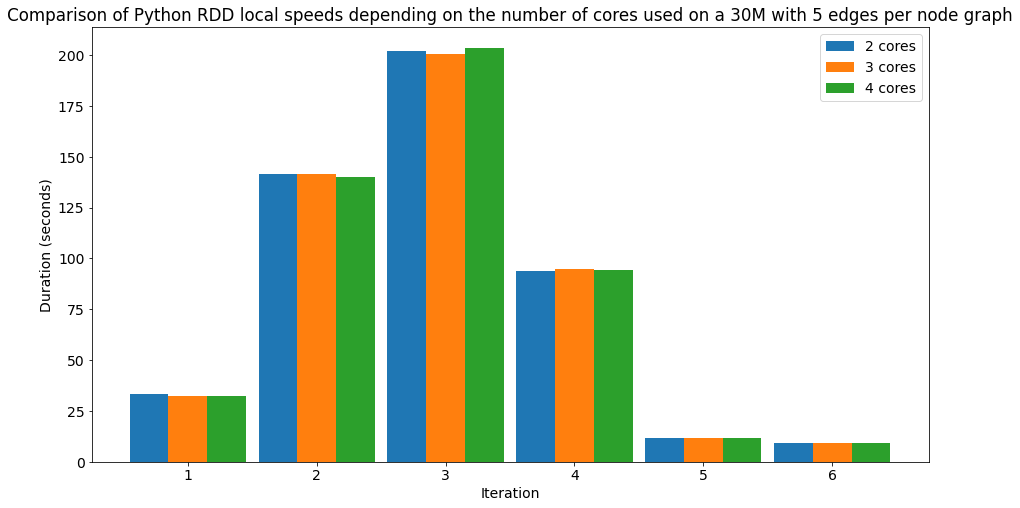

In [13]:
width = 0.3
plt.bar(two_core_logs.index.values - width, height=two_core_logs['duration'], width=width, label='2 cores')
plt.bar(three_core_logs.index.values, height=three_core_logs['duration'], width=width, label='3 cores')
plt.bar(four_core_logs.index.values + width, height=four_core_logs['duration'], width=width, label='4 cores')
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Comparison of Python RDD local speeds depending on the number of cores used on a 30M with 5 edges per node graph')
plt.legend()

In [60]:
def plot_graphs(ax, filenames, source, width, param):
    
    rdd_durations = {}
    df_durations = {}

    for i, filename in enumerate(filenames):

        full_logs = pd.read_csv(os.path.join(root_path, filename))

        rdd_logs = full_logs[full_logs['algo_type'] == 'python-rdd']
        df_logs = full_logs[full_logs['algo_type'] == 'python-df']

        rdd_logs = get_durations(rdd_logs)
        df_logs = get_durations(df_logs)

        rdd_durations[source[i]] = rdd_logs['duration'].sum()
        df_durations[source[i]] = df_logs['duration'].sum()
    
    absciss_rdd = np.array(list(rdd_durations.keys())).reshape(-1, 1)
    lin_reg_rdd = LinearRegression()
    lin_reg_rdd.fit(absciss_rdd, list(rdd_durations.values()))
    x_rdd = np.arange(min(rdd_durations.keys()), max(rdd_durations.keys()) + 1)
    y_rdd = x_rdd * lin_reg_rdd.coef_ + lin_reg_rdd.intercept_
    
    absciss_df = np.array(list(df_durations.keys())).reshape(-1, 1)
    lin_reg_df = LinearRegression()
    lin_reg_df.fit(absciss_df, list(df_durations.values()))
    x_df = np.arange(min(df_durations.keys()), max(df_durations.keys()) + 1)
    y_df = x_df * lin_reg_df.coef_ + lin_reg_df.intercept_

    ax.bar([key - (width / 2) for key in rdd_durations.keys()], color='blue', height=rdd_durations.values(), width=width, label='rdd')
    ax.bar([key + (width / 2) for key in df_durations.keys()], color='red', height=df_durations.values(), width=width, label='dataframe')
    ax.plot(x_rdd, y_rdd, 'b--', label=f"intercept={round(lin_reg_rdd.intercept_, 2)}, coef={round(lin_reg_rdd.coef_[0], 4)}")
    ax.plot(x_df, y_df, 'r--', label=f"intercept={round(lin_reg_df.intercept_, 2)}, coef={round(lin_reg_df.coef_[0], 4)}")
    ax.set_ylabel("Total duration (seconds)")
    ax.set_xlabel("Number of " + param)
    ax.legend()

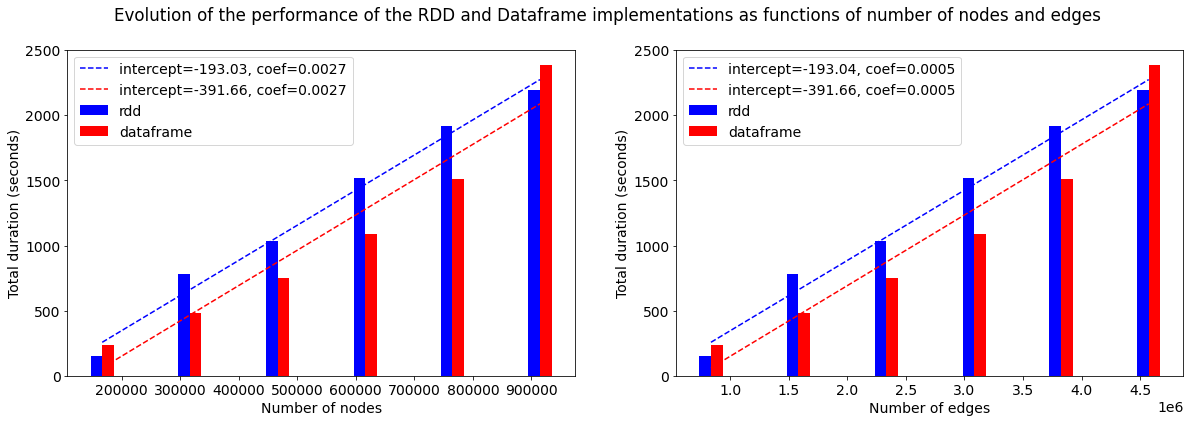

In [65]:
sizes = [10, 20, 30, 40, 50, 60]
nodes = [166_950, 316_202, 466_559, 616_617, 764_818, 914_619]
edges = [834_754, 1_581_012, 2_332_796, 3_083_086, 3_824_094, 4_573_098]

# sizes = [10, 20, 30, 40, 50]
# nodes = [166_950, 316_202, 466_559, 616_617, 764_818]
# edges = [834_754, 1_581_012, 2_332_796, 3_083_086, 3_824_094]

filenames = ["python_rdd_df_" + str(size) + "M_5.csv" for size in sizes]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
plot_graphs(ax[0], filenames, nodes, 20_000, "nodes")
plot_graphs(ax[1], filenames, edges, 100_000, "edges")
fig.suptitle("Evolution of the performance of the RDD and Dataframe implementations as functions of number of nodes and edges")
plt.show()